In [7]:
# Climate: Use Text Similarity (article spinning) to Connect News Media
import pandas as pd
import numpy as np
import os
import sys
import json
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the .npz file
file_path = '/scratch/midway3/maxzhuyt/deeplearning/pairwise_similarity_scores_israel.npz' 
israel = np.load(file_path)
israel = israel['results']
israel_df_pairs = pd.DataFrame(israel)

# Load the .npz file
file_path = '/scratch/midway3/maxzhuyt/deeplearning/pairwise_similarity_scores_climate.npz' 
climate = np.load(file_path)
climate = climate['results']
climate_df_pairs = pd.DataFrame(israel)
israel_df_pairs = israel_df_pairs[(israel_df_pairs['title_sim'] > 0.6) & (israel_df_pairs['article_sim'] > 0.7)]
print(israel_df_pairs.shape)
climate_df_pairs = climate_df_pairs[(climate_df_pairs['title_sim'] > 0.6) & (climate_df_pairs['article_sim'] > 0.7)]
print(climate_df_pairs.shape)

(43591, 4)
(43591, 4)


In [2]:
#df_path = '/home/maxzhuyt/Desktop/deeplearning/climate-change_articles_en.csv'
df_path = '/scratch/midway3/maxzhuyt/israeli-palestinian-conflict_articles_en.csv'
israel_articles = pd.read_csv(df_path)
climate_articles = pd.read_csv("/home/maxzhuyt/Desktop/deeplearning/climate-change_articles_en.csv")


In [3]:
# Remove sources with unknown bias
israel_articles = israel_articles[israel_articles['source_bias'] != 'unknown']
climate_articles = climate_articles[climate_articles['source_bias'] != 'unknown']

In [8]:
df = pd.concat([israel_articles, climate_articles])
print(len(df['source_name'].unique()))
# Count NaN values in source_owners
num_nans = df['source_owners'].isna().sum()
print(f"Number of NaN values in source_owners: {num_nans}")

# Separate rows where source_owners is NaN
df_with_owners = df.dropna(subset=['source_owners'])
sources_wo_owners = df[df['source_owners'].isna()]['source_name'].unique().tolist()

# Count articles per (source_owners, source_name) pair
source_counts = df_with_owners.groupby(['source_owners', 'source_name']).size().reset_index(name='count')

# Find the source name with the maximum count per owner
max_source_names = source_counts.loc[source_counts.groupby('source_owners')['count'].idxmax()]
print(len(sources_wo_owners))
print(len(max_source_names))
all_source_names = sources_wo_owners + max_source_names['source_name'].tolist()

1877
Number of NaN values in source_owners: 20188
1122
310


In [28]:
# Pickle the list
import pickle
with open("selected_source_names.pkl", "wb") as f:
    pickle.dump(all_source_names, f)

print("Pickle file saved as 'all_source_names.pkl'")

Pickle file saved as 'all_source_names.pkl'


In [9]:
# Filter original DataFrame to keep only the selected source_names
israel_articles_deduplicated = israel_articles[israel_articles['source_name'].isin(all_source_names)]
climate_articles_deduplicated = climate_articles[climate_articles['source_name'].isin(all_source_names)]

In [14]:
len(israel_articles_deduplicated.source_name.value_counts().index.tolist())

1008

## Version 1: we deduplicate based on affiliation

In [10]:
# Debugging: Check initial row count
print(f"Rows in israel_df_pairs before mapping: {len(israel_df_pairs)}")

# Ensure israel_articles_deduplicated has a unique index (if needed)
if not israel_articles_deduplicated.index.is_unique:
    print("Warning: israel_articles_deduplicated index is not unique! Resetting index.")

# Create a mapping dictionary from the deduplicated DataFrame
source_name_mapping = israel_articles_deduplicated.set_index(israel_articles_deduplicated.index)['source_name'].to_dict()

# Use .map() instead of .reindex() to safely map non-continuous indices
israel_df_pairs['source_i'] = israel_df_pairs['i'].map(source_name_mapping)
israel_df_pairs['source_j'] = israel_df_pairs['j'].map(source_name_mapping)

# Drop rows where either 'source_i' or 'source_j' is NaN (missing mappings)
israel_df_pairs_final = israel_df_pairs.dropna(subset=['source_i', 'source_j'])

print(f"Remaining rows in israel_df_pairs after deduplication: {len(israel_df_pairs)}")


Rows in israel_df_pairs before mapping: 43591
Remaining rows in israel_df_pairs after deduplication: 43591


In [20]:
israel_df_pairs_final

,i,j,title_sim,article_sim,source_i,source_j
80868,1,4,1.000000,1.000000,The Independent,Associated Press News
80870,1,6,0.666639,1.000000,The Independent,abc News
103656,4,6,0.666639,1.000000,Associated Press News,abc News
103665,4,24,1.000000,1.000000,Associated Press News,Military.com
205437,6,24,0.666639,1.000000,abc News,Military.com
...,...,...,...,...,...,...
437212587,41367,41368,1.000000,1.000000,Jewish Press,NEWSRAEL
437213462,41371,41372,1.000000,1.000000,WIN,Frontpage Mag
437223627,41673,41674,0.804494,0.743657,Deadline,The Hollywood Reporter
437231882,41651,41652,0.820539,1.000000,scheerpost.com,juancole.com


In [33]:
import random

# Sample 15 random indices from the DataFrame
sampled_indices = random.sample(list(israel_df_pairs_final.index), 150)

for row in [393379220]+ sampled_indices:
    try:
        # Extract indices of similar articles
        index1 = israel_df_pairs_final.loc[row, 'i']
        index2 = israel_df_pairs_final.loc[row, 'j']
        
        
        # Retrieve the corresponding article rows
        article1 = israel_articles_deduplicated.iloc[index1]
        article2 = israel_articles_deduplicated.iloc[index2]
        if article1['story_id'] != article2['story_id']:
            continue
        # Print only the required fields
        print(f"\n**Pair {row}:**")
        print(israel_df_pairs_final.loc[row, 'title_sim'])
        print(israel_df_pairs_final.loc[row, 'article_sim'])
        print(f"Article 1 ({article1['source_name']} - {article1['source_bias']}):")
        print(f"  - Date Published: {article1['article_date_publish']}")
        print(f"  - Date Published: {article1['story_id']}")
        print(f"  - Article Title: {article1['article_title']}")
        print(f"  - Title: {article1['title']}")
        print(f"  - URL: {article1['url']}")
        
        print(f"\nArticle 2 ({article2['source_name']} - {article2['source_bias']}):")
        print(f"  - Date Published: {article2['story_id']}")
        print(f"  - Date Published: {article2['article_date_publish']}")
        print(f"  - Article Title: {article2['article_title']}")
        print(f"  - Title: {article2['title']}")
        print(f"  - URL: {article2['url']}")
        print("-" * 80)

    except KeyError as e:
        print(f"KeyError at index {row}: {e}")
    except IndexError as e:
        print(f"IndexError at index {row}: {e}")
    except Exception as e:
        print(f"Unexpected error at index {row}: {e}")



**Pair 393379220:**
1.0000000000000002
1.0000000000000002
Article 1 (intellinews.com - center):
  - Date Published: 2024-11-28 00:00:00
  - Date Published: 5b388169-7566-42dc-adfb-bc0844c17b7a
  - Article Title: Israel, Lebanon in disarray over reports of ceasefire failure
  - Title: Israel, Lebanon in disarray over reports of ceasefire failure
  - URL: https://www.intellinews.com/israel-lebanon-in-disarray-over-reports-of-ceasefire-failure-355640/

Article 2 (Israel Unwired - farRight):
  - Date Published: 5b388169-7566-42dc-adfb-bc0844c17b7a
  - Date Published: 2024-11-28 16:59:40
  - Article Title: CEASEFIRE VIOLATION: Israel Takes Out Terrorists After Hezbollah Activity Spotted
  - Title: CEASEFIRE VIOLATION: Israel Takes Out Terrorists After Hezbollah Activity Spotted - Israel Unwired
  - URL: https://www.israelunwired.com/ceasefire-violation-israel-takes-out-terrorists-after-hezbollah-activity-spotted/
-----------------------------------------------------------------------------

## Version 2: we do not deduplicate based on affiliation

In [5]:
# Debugging: Check initial row count
print(f"Rows in israel_df_pairs before mapping: {len(israel_df_pairs)}")

# Ensure israel_articles_deduplicated has a unique index (if needed)
if not israel_articles.index.is_unique:
    print("Warning: israel_articles_deduplicated index is not unique! Resetting index.")

# Create a mapping dictionary from the deduplicated DataFrame
source_name_mapping = israel_articles.set_index(israel_articles.index)['source_name'].to_dict()

# Use .map() instead of .reindex() to safely map non-continuous indices
israel_df_pairs['source_i'] = israel_df_pairs['i'].map(source_name_mapping)
israel_df_pairs['source_j'] = israel_df_pairs['j'].map(source_name_mapping)

# Drop rows where either 'source_i' or 'source_j' is NaN (missing mappings)
israel_df_pairs_final = israel_df_pairs.dropna(subset=['source_i', 'source_j'])

print(f"Remaining rows in israel_df_pairs after deduplication: {len(israel_df_pairs)}")


Rows in israel_df_pairs before mapping: 43591
Remaining rows in israel_df_pairs after deduplication: 43591


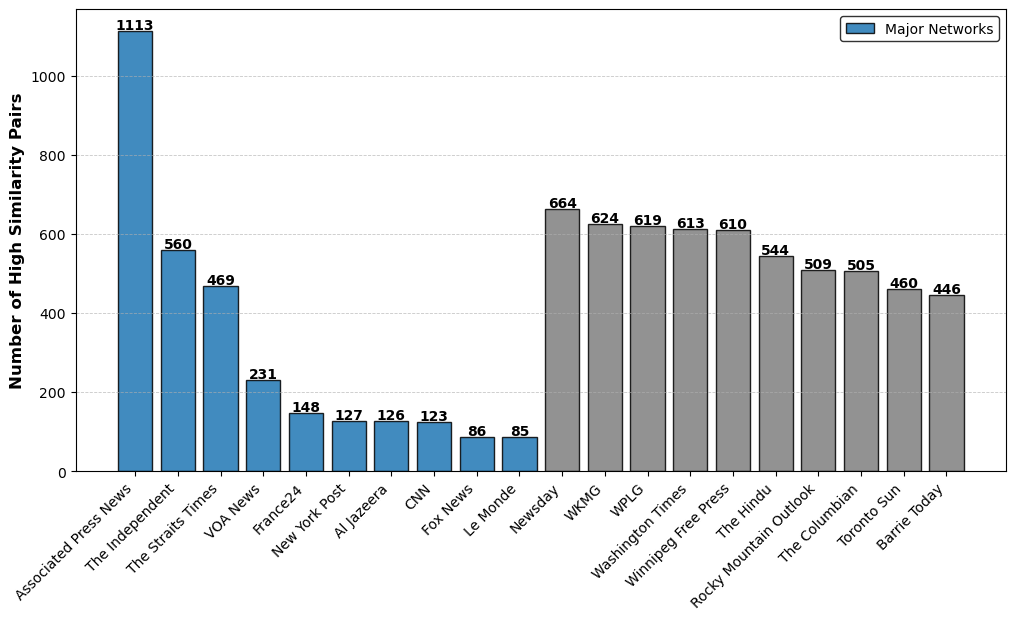

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# List of major networks
major_networks = ["Al Jazeera", "The Independent", "Associated Press News", "France24",
                  "New York Post", "Fox News", "ABC News", "BBC News", "CNN",
                  "VOA News", "The Straits Times", 'Bloomberg', 'Financial Times', 'Sky News UK', 'CBC News', 'Le Monde']

# Count occurrences for all sources without separating beforehand
all_counts = pd.concat([israel_df_pairs_final['source_i'], israel_df_pairs_final['source_j']]).value_counts()

# Separate major networks and other media after counting
major_counts = all_counts[all_counts.index.isin(major_networks)].head(10)  # Top 10 major networks
other_counts = all_counts[~all_counts.index.isin(major_networks)].head(10)  # Top 10 other media

# Combine both for visualization
combined_counts = pd.concat([major_counts, other_counts])
categories = ["Major Networks"] * len(major_counts) + ["Other Media"] * len(other_counts)

# Define professional colors
major_color = "#1f77b4"  # Dark blue for major networks
other_color = "#7f7f7f"  # Dark gray for other media
colors = [major_color if category == "Major Networks" else other_color for category in categories]

# Bar chart settings
plt.figure(figsize=(12, 6))
bars = plt.bar(combined_counts.index, combined_counts.values, color=colors, edgecolor="black", alpha=0.85)

# Add value labels above bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(int(bar.get_height())), ha="center", fontsize=10, fontweight="bold")

# Labels and formatting
plt.ylabel("Number of High Similarity Pairs", fontsize=12, fontweight="bold")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.7)

# Custom legend
plt.legend(["Major Networks", "Other Media"], loc="upper right", fontsize=10, frameon=True, edgecolor="black")

# Display the chart
plt.show()


In [23]:
israel_articles_deduplicated['date'].count()

34908

In [9]:
import networkx as nx
G = nx.DiGraph()

for row in df_results.iterrows():
    i = row[1]['i']
    j = row[1]['j']
    
    # Skip rows if i or j are not in df's index
    if i not in df.index or j not in df.index:
        continue

    try:
        source_i = df.loc[i, 'source_name']
        source_j = df.loc[j, 'source_name']
        time_i = df.loc[i, 'article_date_publish']
        time_j = df.loc[j, 'article_date_publish']
    except Exception as exc:
        print(f"Error retrieving data for indices {i} and {j}: {exc}")
        continue

    try:
        if source_i != source_j:
            # Decide direction based on publication time
            if time_i < time_j:
                s = source_i
                e = source_j
            else:
                s = source_j
                e = source_i
            # Increment edge weight if edge exists, otherwise add a new edge
            if G.has_edge(s, e):
                G[s][e]['weight'] += 1
            else:
                G.add_edge(s, e, weight=1)
    except Exception as exc:
        #print(f"Error processing sources {source_i} and {source_j}: {exc}")
        continue

# Check nodes in G by out_degree
out_degree = dict(G.out_degree())
out_degree = {k: v for k, v in sorted(out_degree.items(), key=lambda item: item[1], reverse=True)[:20]}
print(out_degree)

{'Associated Press News': 219, 'Washington Top News': 179, 'Washington Times': 177, 'NY1': 176, 'The Columbian': 176, 'KTVB': 168, 'Military.com': 166, 'Winnipeg Free Press': 162, 'Hindustan Times': 153, 'Newsday': 152, 'WPLG': 151, 'WKMG': 147, 'WKYC': 143, 'DNyuz': 141, 'WBIR': 140, 'Rocky Mountain Outlook': 140, 'The Hindu': 140, 'WCSH': 140, 'Krem2 News': 139, 'Barrie Today': 138}


In [10]:
import pickle
with open("/scratch/midway3/maxzhuyt/deeplearning/israel_graph_6_7.gpickle", "wb") as f:
    pickle.dump(G, f)

print("Graph saved")

Graph saved
